In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

C:\Users\atami\anaconda3\envs\jcopdl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('data/breast_cancer.csv')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [23]:
df.target.value_counts()

1.0    357
0.0    212
Name: target, dtype: int64

In [5]:
df.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [6]:
X = df.drop(columns="target")
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

## PCA

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns

In [26]:
pca = PCA(n_components=2, whiten=True) # minimal jika mau plot hrs 2, whiten = standard scalling

In [27]:
XTrain_PCA = pca.fit_transform(X_train)
XTest_PCA = pca.transform(X_test)

In [28]:
XTrain_PCA.shape

(455, 3)

<AxesSubplot: >

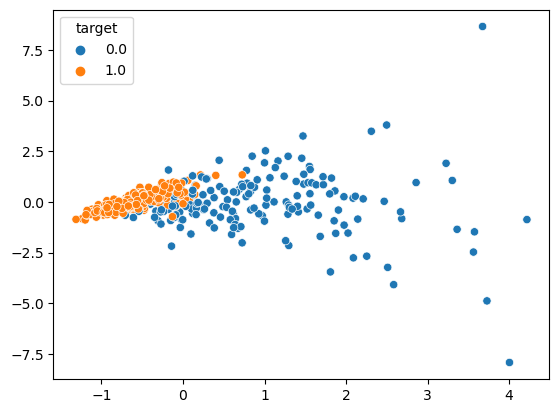

In [32]:
sns.scatterplot(x=XTrain_PCA[:, 0], y=XTrain_PCA[:, 1], hue=y_train)

## Training

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.svm import SVC
from jcopml.tuning.space import Real, Integer

In [37]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA()),
    ('algo', SVC(max_iter=500))
])

parameter = {
    'algo__gamma': Real(low=-3, high=3, prior='log-uniform'), # 10 pangkat -3 sampai 10 pow3
    'algo__C': Real(low=-3, high=3, prior='log-uniform'),
    'pca__n_components': Integer(1,30),
    'pca__whiten': [True, False]
}

model = RandomizedSearchCV(pipeline ,parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 3.907967156822884, 'algo__gamma': 0.008632008168602547, 'pca__n_components': 19, 'pca__whiten': True}
0.9736263736263736 0.9582607180202162 0.9736842105263158


## menentukan n_components dengan cumulative explained variance (CEV)

In [38]:
pca = PCA().fit(X_train)

Text(0.5, 0, 'CVE')

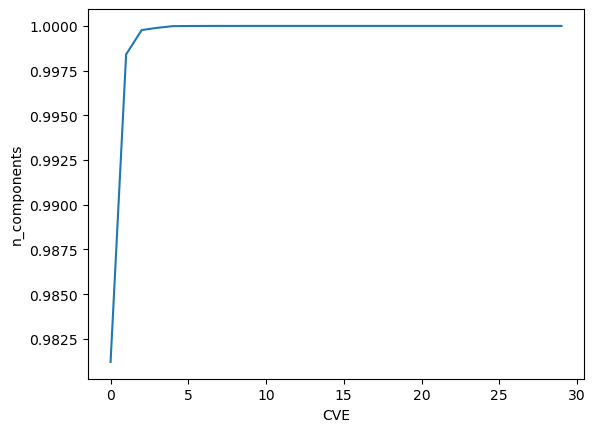

In [39]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('n_components')
plt.xlabel('CVE')